In [2]:
!pip install torchinfo -q

In [16]:
# Import PyTorch for deep learning computations
import torch
# Import torchvision for pre-trained models and datasets
import torchvision
# Import neural network module from PyTorch
import torch.nn as nn
# Import optimizers for training models
import torch.optim as optim
# Import time module for measuring execution time
import time
# Import NumPy for numerical operations
import numpy as np
# Import Matplotlib for visualizations
import matplotlib.pyplot as plt
# Import os for file system operations
import os
# Import zipfile for extracting compressed datasets
import zipfile
# Import requests for downloading files
import requests

# Import pandas for data manipulation and analysis
import pandas as pd
# Import PIL for image processing
from PIL import Image
# Import datasets, pre-trained models, and transformations from torchvision
from torchvision import datasets, models, transforms
# Import torchinfo for displaying model summaries
from torchinfo import summary
# Import DataLoader for handling batch data loading
from torch.utils.data import DataLoader

# Set the Matplotlib style to 'ggplot' for better visualization
plt.style.use('ggplot')

In [17]:
# Helper function to download file
def download_file(url, save_name):
    url = url
    if not os.path.exists(save_name):
        file = requests.get(url)
        open(save_name, 'wb').write(file.content)

In [18]:
# Download the dataset.
download_file(
    'https://www.dropbox.com/s/0ltu2bsja3sb2j4/caltech256_subset.zip?dl=1',
    'caltech256_subset.zip'
)

In [19]:
# Extract the dataset
file = 'caltech256_subset.zip'
with zipfile.ZipFile(file, 'r') as zip:
    # Extract all files
    print("extraction...")
    zip.extractall()
    print("done!")

extraction...
done!


In [20]:
# Preprocessing Transforms
# Defining transformations to be applied to training, validation, and test datasets
image_transforms = {
    'train': transforms.Compose([
        # Randomly crop the image with scaling
        transforms.RandomResizedCrop(size = 256, scale = (0.8, 1.0)),
        # Apply random rotation up to 15 degrees
        transforms.RandomRotation(degrees = 15),
        # Flip the image horizontally with a probability of 0.5
        transforms.RandomHorizontalFlip(),
        # Crop the center of image to 224 x 224 pixels
        transforms.CenterCrop(size = 224),
        # Convert image to PyTorch Tensor format
        transforms.ToTensor(),
                             # Normalize image using mean
        transforms.Normalize([0.485, 0.456, 0.406],
                             # Normalize image using std deviation
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        # Resize the image to 256 pixels on the shorter side
        transforms.Resize(size = 256),
        # Crop the center of the image to 224 x 224 pixels
        transforms.CenterCrop(size = 224),
        # Convert image to PyTorch tensor format
        transforms.ToTensor(),
                             # Normalize image using mean
        transforms.Normalize([0.485, 0.456, 0.406],
                             # Normalize image using std deviation
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        # Resize image to 256 pixels on the shorter side
        transforms.Resize(size = 256),
        # Crop the center of the image to 224 x 224 pixels
        transforms.CenterCrop(size = 224),
        # Convert image to PyTorch tensor format
        transforms.ToTensor(),
                             # Normalize image using mean
        transforms.Normalize([0.485, 0.456, 0.406],
                             # Normalize image using std deviation
                             [0.229, 0.224, 0.225])
    ])
}

In [21]:
# Dataset Preparation
# Load the data
# Set train and valid directory paths

dataset = 'caltech256_subset'

train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'valid')
test_directory = os.path.join(dataset, 'test')

# Batch size
batch_size = 32

# Number of classes
num_classes = len(os.listdir(valid_directory))
print(num_classes)

# Load data from folders
data = {
    'train': datasets.ImageFolder(root = train_directory, transform = image_transforms['train']),
    'valid': datasets.ImageFolder(root = valid_directory, transform = image_transforms['valid']),
    'test': datasets.ImageFolder(root = test_directory, transform = image_transforms['test'])
}

# Get mapping of the indices to the class names, in order to see the output classes
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Size of data, to be used for calculating average loss and accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the data loader using dataloader module
train_data_loader = DataLoader(data['train'], batch_size = batch_size, shuffle = True)
valid_data_loader = DataLoader(data['valid'], batch_size = batch_size, shuffle = False)
test_data_loader = DataLoader(data['test'], batch_size = batch_size, shuffle = False)

10
{0: 'bear', 1: 'chimp', 2: 'giraffe', 3: 'gorilla', 4: 'llama', 5: 'ostrich', 6: 'porcupine', 7: 'skunk', 8: 'triceratops', 9: 'zebra'}


In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Number of training samples: {train_data_size}")
print(f"Number of validation samples: {valid_data_size}")
print(f"Number of test samples: {test_data_size}")

Number of training samples: 600
Number of validation samples: 100
Number of test samples: 100


In [23]:
# Load pretrained ResNet50 Model
resnet50 = models.resnet50(weights = 'DEFAULT')
resnet50 = resnet50.to(device)

In [24]:
# Freeze model parameters
for param in resnet50.parameters():
    param.requires_grad = False

In [25]:
# Change the final fully connected layer of the ResNet50 model for transfer learning

# Get the number of input features for the final layer
fc_inputs = resnet50.fc.in_features

# Define a new fully connected layer with custom architecture for classification
resnet50.fc = nn.Sequential(
    # Fully connected layer with 256 neurons
    nn.Linear(fc_inputs, 256),
    # Apply ReLU activation
    nn.ReLU(),
    # Apply dropout with 40% probability to prevent overfitting
    nn.Dropout(0.4),
    # Output layer with number of classes as output neurons
    nn.Linear(256, num_classes),
    # Apply LogSoftmax for multi-class classification (used with NLLLoss)
    nn.LogSoftmax(dim = 1)
)

# Move the model to the appropriate device (either CUDA or CPU)
resnet50 = resnet50.to(device)

In [27]:
# Training Configuration
# Define the loss function for classification
# NLLLoss is suitable for multi-class classification
loss_func = nn.NLLLoss()

# Define the learning rate for the optimizer
# Initial learning rate for the optimizer
learning_rate = 0.01

# Define the optimizer using Stochastic Gradient Descent (SGD)
optimizer = optim.SGD(
    # Optimizing all parameters of the ResNet50 model
    params = resnet50.parameters(),
    # Learning rate value
    lr = learning_rate,
    # Momentum term to improve convergence and avoid local minima
    momentum = 0.9
)

In [60]:
# Model Training
def train_and_validate(model, loss_criterion, optimizer, epochs = 25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default = 25)

    Returns
        model: Trained model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''

    start = time.time()
    history = []
    best_loss = 100000.0
    best_epoch = None

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        # Set to training mode
        model.train()

        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(train_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
    
            # Clean existing gradients
            optimizer.zero_grad()
    
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
    
            # Compute loss
            loss = loss_criterion(outputs, labels)
    
            # Backpropagate the gradients
            loss.backward()
    
            # Update the parameters
            optimizer.step()
    
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
    
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
    
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
    
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)

        # Validation - No gradient tracking needed
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()
    
            # Validation loop
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)
    
                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)
    
                # Compute loss
                loss = loss_criterion(outputs, labels)
    
                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)
    
                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
    
                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
    
                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)
    
            if valid_loss < best_loss:
                best_loss = valid_loss
                best_epoch = epoch
    
                # Save if the model has best accuracy till now
                torch.save(model, 'best_model.pt')
    
        # Find average training loss and traning accuracy
        avg_train_loss = train_loss / train_data_size
        avg_train_acc = train_acc / train_data_size
    
        # Find average valid loss and valid accuracy
        avg_valid_loss = valid_loss / valid_data_size
        avg_valid_acc = valid_acc / valid_data_size
    
        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
        print(f"Epoch {epoch + 1}: Train Loss = {avg_train_loss}, Valid Loss = {avg_valid_loss}")
        print(f"History length: {len(history)}")
    
    
        epoch_end = time.time()
    
        print("Epoch: {:03d}, Training: Loss - {:.4f}, Accuracy - {:.4f}%, \n\t\Validation: Loss - {:.4f}, Accuracy - {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc * 100, avg_valid_loss, avg_valid_acc * 100, epoch_end-epoch_start))

    return model, history, best_epoch

In [61]:
# Print model to be trained
print(summary(resnet50, input_size = (batch_size, 3, 224, 224)))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 10]                  --
├─Conv2d: 1-1                            [32, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        (128)
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          (4,096)
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]   

In [62]:
# Train the model
num_epochs = 25
trained_model, history, best_epoch = train_and_validate(resnet50, loss_func, optimizer, num_epochs)

torch.save(history, dataset+'_history.pt')

Epoch: 1/25
Epoch 1: Train Loss = 0.1336090079943339, Valid Loss = 0.17219261081889273
History length: 1
Epoch: 000, Training: Loss - 0.1336, Accuracy - 98.0000%, 
	\Validation: Loss - 0.1722, Accuracy - 95.0000%, Time: 7.9448s
Epoch: 2/25
Epoch 2: Train Loss = 0.11564049104849497, Valid Loss = 0.17230185110121965
History length: 2
Epoch: 001, Training: Loss - 0.1156, Accuracy - 97.6667%, 
	\Validation: Loss - 0.1723, Accuracy - 95.0000%, Time: 7.5069s
Epoch: 3/25
Epoch 3: Train Loss = 0.1164019678036372, Valid Loss = 0.17268244879320263
History length: 3
Epoch: 002, Training: Loss - 0.1164, Accuracy - 97.8333%, 
	\Validation: Loss - 0.1727, Accuracy - 95.0000%, Time: 7.9716s
Epoch: 4/25
Epoch 4: Train Loss = 0.10509446074565251, Valid Loss = 0.15671209121122956
History length: 4
Epoch: 003, Training: Loss - 0.1051, Accuracy - 97.6667%, 
	\Validation: Loss - 0.1567, Accuracy - 96.0000%, Time: 8.1453s
Epoch: 5/25
Epoch 5: Train Loss = 0.08931737105051676, Valid Loss = 0.1576635464467108

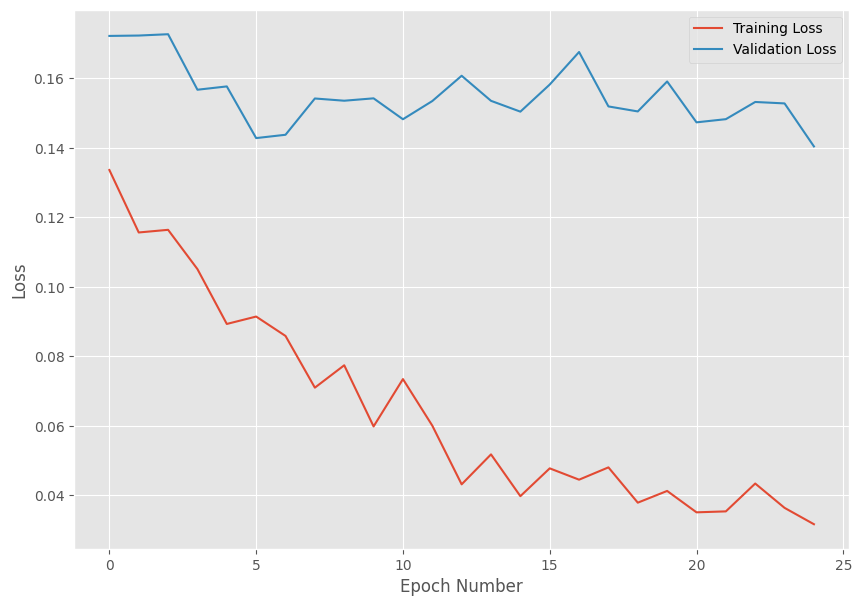

(25, 4)


In [63]:
plt.figure(figsize = (10, 7))
history = np.array(history, dtype = float)
plt.plot(history[:, 0], label = "Training Loss")
plt.plot(history[:, 1], label ='Validation Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_curve.png')
plt.show()
print(history.shape)

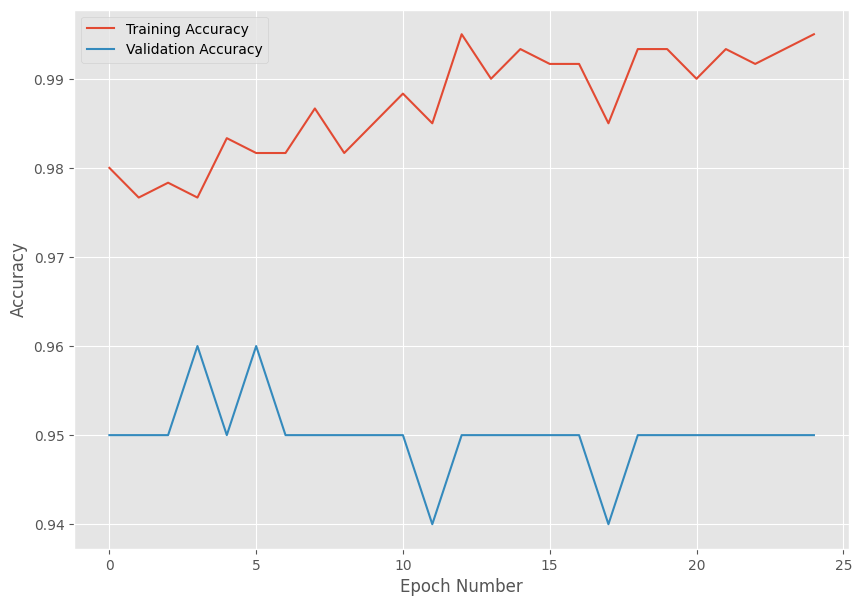

In [64]:
plt.figure(figsize=(10, 7))
plt.plot(history[:,2:4])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.savefig('accuracy_curve.png')
plt.show()

In [65]:
def computeTestSetAccuracy(model, loss_criterion):
    """
    Computes the accuracy and loss of the model on the test dataset.

    Parameters:
    model (torch.nn.Module): The trained model to evaluate.
    loss_criterion (torch.nn.Module): The loss function used for evaluation.

    The function runs inference on the test dataset without tracking gradients,
    calculates the loss and accuracy for each batch, and returns the average loss and accuracy.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    test_acc = 0.0
    test_loss = 0.0

    # Validation - No gradient tracking needed
    with torch.no_grad():
        # Set to evaluation mode
        model.eval()

        # Validation loop
        for j, (inputs, labels) in enumerate(test_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Compute the total loss for the batch and add it to test_loss
            test_loss += loss.item() * inputs.size(0)

            # Calculate test accuracy
            _, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to test_acc
            test_acc += acc.item() * inputs.size(0)

            print(f"Test Batch number: {j:03d}, Test: Loss: {loss.item():.4f}, Accuracy: {acc.item():.4f}")

    # Find average test loss and test accuracy
    avg_test_loss = test_loss / test_data_size
    avg_test_acc = test_acc / test_data_size

    print("Test accuracy: {:.4f}".format(avg_test_acc))


In [67]:
# Load the best saved model during training.
model = torch.load("best_model.pt".format(dataset, best_epoch), weights_only = False)
# Evaluate the model's performance on the test dataset and print the results.
computeTestSetAccuracy(model, loss_func)

Test Batch number: 000, Test: Loss: 0.1159, Accuracy: 0.9688
Test Batch number: 001, Test: Loss: 0.1985, Accuracy: 0.9062
Test Batch number: 002, Test: Loss: 0.0151, Accuracy: 1.0000
Test Batch number: 003, Test: Loss: 0.0004, Accuracy: 1.0000
Test accuracy: 0.9600


In [68]:
def predict(model, test_image_name):
    """
    Predicts the class of a given test image using a trained model.

    Parameters:
    model (torch.nn.Module): The trained model to use for prediction.
    test_image_name (str): The file path of the test image.

    The function loads the image, applies necessary transformations, and
    passes it through the model to get the top 3 predictions with their confidence scores.
    """
    # Applies the predefined transformation pipeline for test images
    transform = image_transforms['test']

    test_image = Image.open(test_image_name)

    # Creates a figure to visualize the test image
    plt.figure(figsize=(10, 7))
    plt.imshow(test_image)  # Displays the test image before applying transformations
    plt.axis('off')  # Removes the axis for a cleaner image visualization

    # Apply transformations and reshape to fit model input
    test_image_tensor = transform(test_image)
    test_image_tensor = test_image_tensor.view(1, 3, 224, 224)  # Reshape for batch processing

    # Checks if a GPU is available and moves the tensor to CUDA if possible
    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.cuda()

    with torch.no_grad():  # Disables gradient computation to optimize inference performance
        model.eval()  # Set model to evaluation mode
        out = model(test_image_tensor)  # Get model predictions
        ps = torch.exp(out)  # Convert log probabilities to actual probabilities

        # Extract the top 3 predictions and their probabilities
        topk, topclass = ps.topk(3, dim=1)
        cls = idx_to_class[topclass.cpu().numpy()[0][0]]  # Get the top predicted class
        score = topk.cpu().numpy()[0][0]  # Get the top prediction confidence score

        # Print the top 3 predictions with their confidence scores
        for i in range(3):
            print(f"Prediction {i+1}: {idx_to_class[topclass.cpu().numpy()[0][i]]}",
                  f"Score: {topk.cpu().numpy()[0][i]*100:.3f}%")


In [69]:
!wget -q "https://learnopencv.com/wp-content/uploads/2022/10/skunk.jpg" -O "skunk.jpg"
!wget -q "https://learnopencv.com/wp-content/uploads/2024/02/Zebra.jpg" -O "Zebra.jpg"
!wget -q "https://learnopencv.com/wp-content/uploads/2024/07/llama-scaled.jpg" -O "llama.jpg"
!wget -q "https://learnopencv.com/wp-content/uploads/2024/07/llama_-scaled.jpg" -O "llama_.jpg"

Prediction 1: skunk Score: 99.922%
Prediction 2: porcupine Score: 0.065%
Prediction 3: ostrich Score: 0.004%


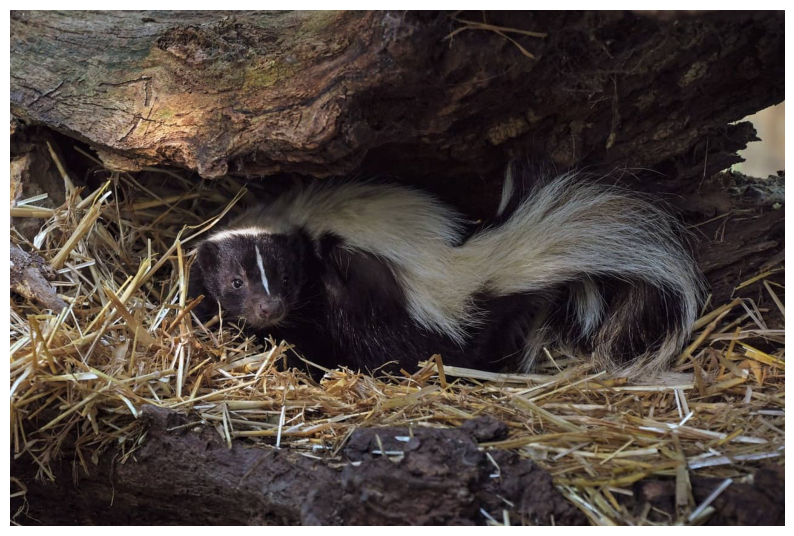

In [70]:
predict(model, 'skunk.jpg')

Prediction 1: zebra Score: 99.994%
Prediction 2: giraffe Score: 0.004%
Prediction 3: ostrich Score: 0.001%


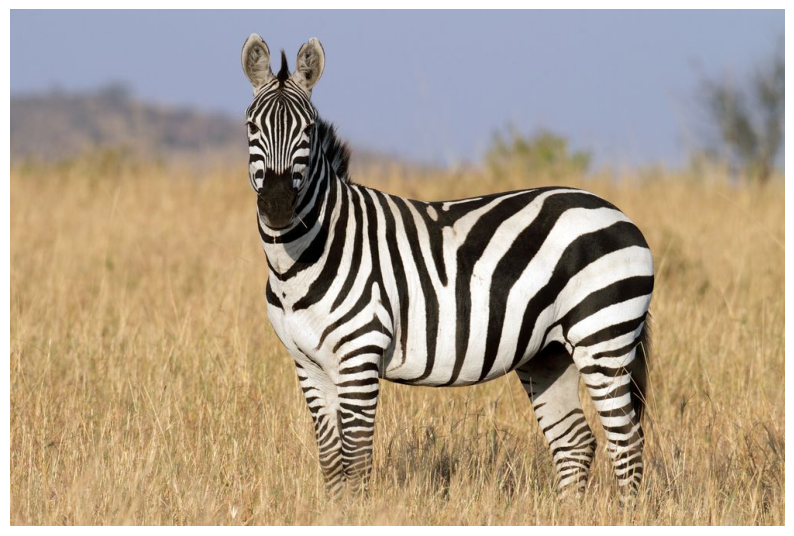

In [71]:
predict(model, 'Zebra.jpg')

Prediction 1: bear Score: 41.156%
Prediction 2: chimp Score: 22.127%
Prediction 3: llama Score: 15.308%


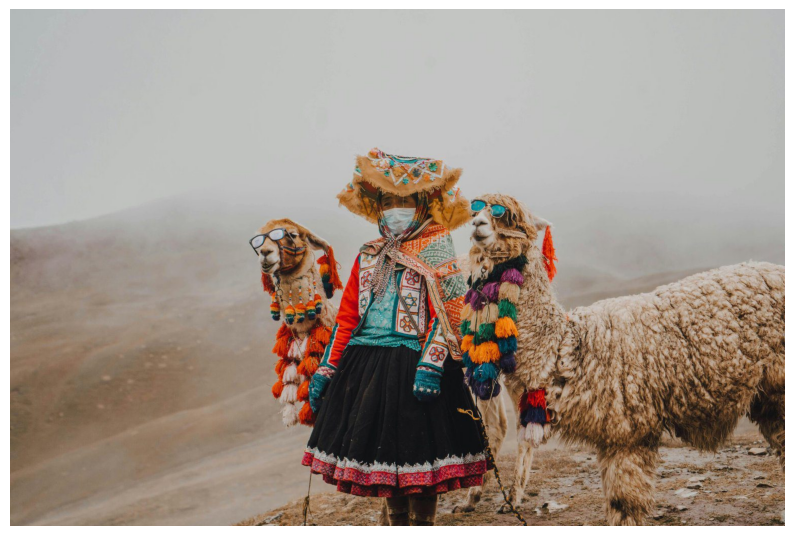

In [72]:
predict(model, 'llama.jpg')

Prediction 1: llama Score: 99.881%
Prediction 2: giraffe Score: 0.056%
Prediction 3: ostrich Score: 0.030%


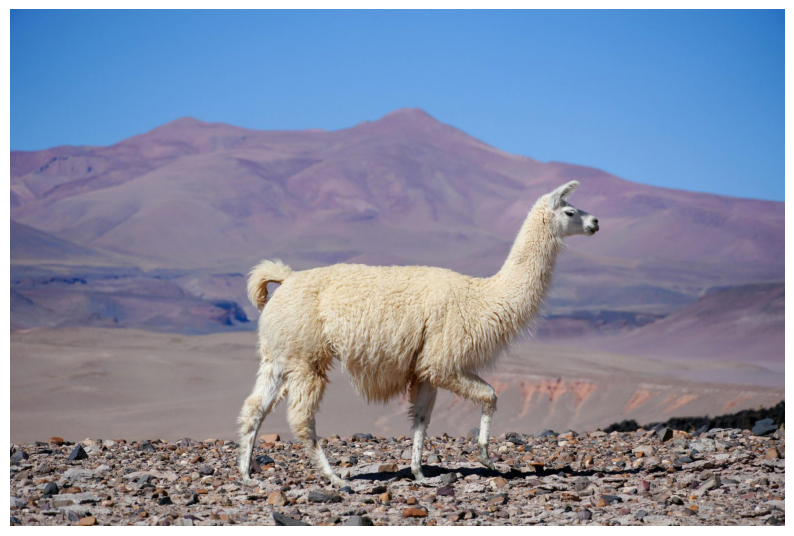

In [73]:
predict(model, 'llama_.jpg')